In [26]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import os


In [134]:
import os
import numpy as np 
import pandas as pd 

import imageio

import matplotlib.pyplot as plt
%matplotlib inline


path = '/Users/abdulmateen/Downloads/car-segmentation' 
image_path = os.path.join(path, './images')
mask_path = os.path.join(path, './masks')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+"/"+i for i in image_list]
mask_list = [mask_path+"/"+i for i in mask_list]



/var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/ipykernel_32661/4185214025.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/var/folders/lm/pf6bl2rd3vs5gtjdk6tsv7mh0000gn/T/ipykernel_32661/4185214025.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

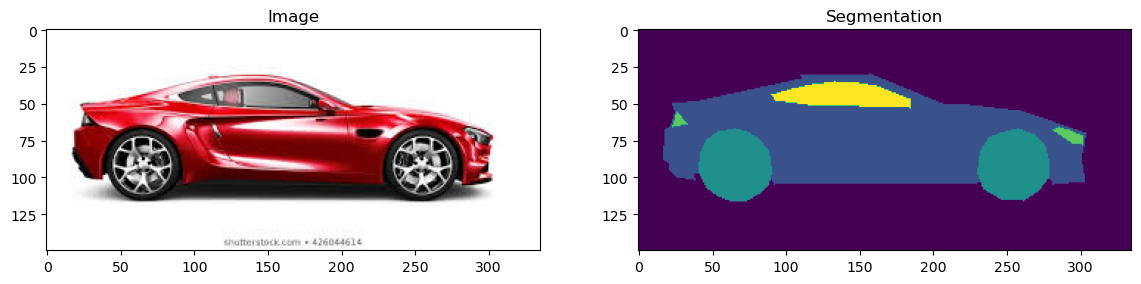

In [58]:
N = 9
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

Splitting the dataset into masked and unmasked images

In [60]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/abdulmateen/Downloads/car-segmentation/./images/003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/abdulmateen/Downloads/car-segmentation/./masks/003.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/abdulmateen/Downloads/car-segmentation/./images/105618339-super-purple-modern-suv-car-side-view.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/abdulmateen/Downloads/car-segmentation/./masks/105618339-super-purple-modern-suv-car-side-view.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/abdulmateen/Downloads/car-segmentation/./images/105618639-modern-pale-blue-suv-car-side-view.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/abdulmateen/Downloads/car-segmentation/./masks/105618639-modern-pale-blue-suv-car-side-view.png'>)


In [61]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/Users/abdulmateen/Downloads/car-segmentation/./images/IMG_20201123_143129__01.png', shape=(), dtype=string)
tf.Tensor(b'/Users/abdulmateen/Downloads/car-segmentation/./masks/IMG_20201123_143129__01.png', shape=(), dtype=string)


Preprocessing the data

In [62]:
# Setting the images between 0 and 1
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

U-Net architecture

In [65]:

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,    
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
# input_size=(96, 128, 3)
# n_filters = 32
# inputs = Input(input_size)
# cblock1 = conv_block(inputs, n_filters * 1)
# model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

# output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
#             ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
#             ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
#             ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

# print('Block 1:')
# # for layer in summary(model1):
# #     print(layer)

# # comparator(summary(model1), output1)

# inputs = Input(input_size)
# cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
# model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

# output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
#             ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
#             ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
#             ['Dropout', (None, 96, 128, 1024), 0, 0.1],
#             ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
# print('\nBlock 2:')   
# for layer in summary(model2):
#     print(layer)
    
# comparator(summary(model2), output2)

In [66]:

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,   
                 3,    
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   
                 3,    
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  
                 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [67]:
# input_size1=(12, 16, 256)
# input_size2 = (24, 32, 128)
# n_filters = 32
# expansive_inputs = Input(input_size1)
# contractive_inputs =  Input(input_size2)
# cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
# model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

# output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
#             ['Conv2DTranspose', (None, 24, 32, 32), 73760],
#             ['InputLayer', [(None, 24, 32, 128)], 0],
#             ['Concatenate', (None, 24, 32, 160), 0],
#             ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
#             ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

# print('Block 1:')
# for layer in summary(model1):
#     print(layer)

# comparator(summary(model1), output1)

In [80]:

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=5):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
   
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters=n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters=n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters=n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters=n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters=n_filters)
    

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

Set model dimensions

In [81]:
# import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
# comparator(summary(unet), outputs.unet_model_output)


In [82]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 96, 128, 32)  896         ['input_3[0][0]']                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_40[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_41[0][0]']        

In [83]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(750, 1000, 1)


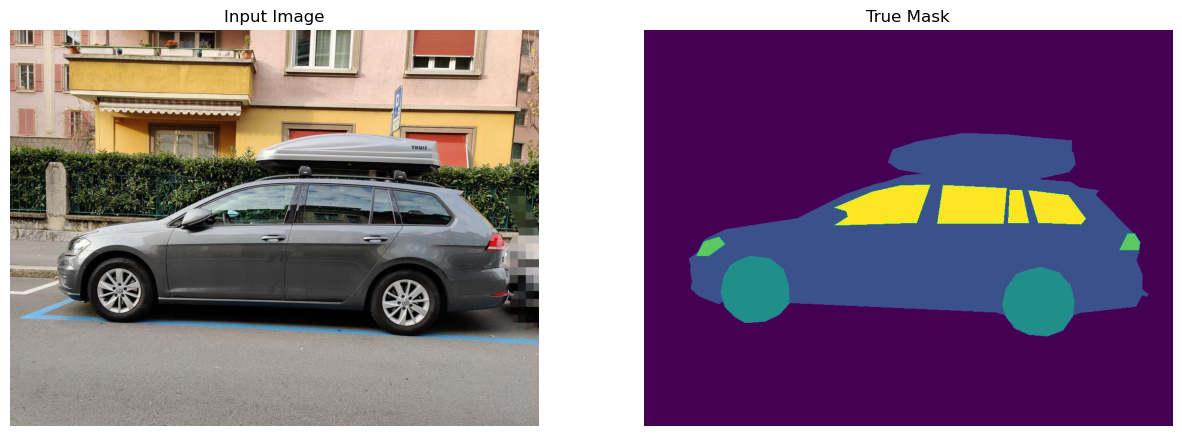

In [85]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [91]:
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/100


2023-06-03 11:31:34.922835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:35.595641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:35.623604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:37.789498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:37.817613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:39.498867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:40.014939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:40.020090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-06-03 11:31:41.296260: W tensorflow/core/lib/png/png_io.cc:88] PNG 

7/7 [==============================] - 18s 1s/step - loss: 0.1194 - accuracy: 0.9530
Epoch 2/100
7/7 [==============================] - 10s 1s/step - loss: 0.1136 - accuracy: 0.9545
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 0.1103 - accuracy: 0.9562
Epoch 4/100
7/7 [==============================] - 10s 1s/step - loss: 0.1058 - accuracy: 0.9578
Epoch 5/100
7/7 [==============================] - 6s 760ms/step - loss: 0.1041 - accuracy: 0.9582
Epoch 6/100
7/7 [==============================] - 5s 680ms/step - loss: 0.1050 - accuracy: 0.9579
Epoch 7/100
7/7 [==============================] - 5s 671ms/step - loss: 0.1030 - accuracy: 0.9587
Epoch 8/100
7/7 [==============================] - 5s 715ms/step - loss: 0.1015 - accuracy: 0.9589
Epoch 9/100
7/7 [==============================] - 5s 722ms/step - loss: 0.0979 - accuracy: 0.9605
Epoch 10/100
7/7 [==============================] - 5s 701ms/step - loss: 0.0945 - accuracy: 0.9617
Epoch 11/100
7/7 [============

Create predicted masks

In [92]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

Plotting model accuracy

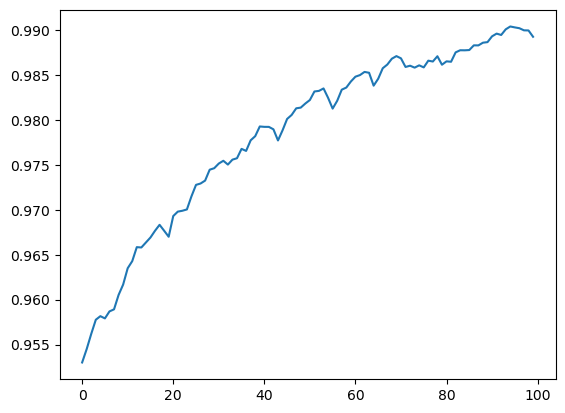

In [93]:
plt.plot(model_history.history["accuracy"])

Making pridictions and checking with true masked

In [94]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 225ms/step


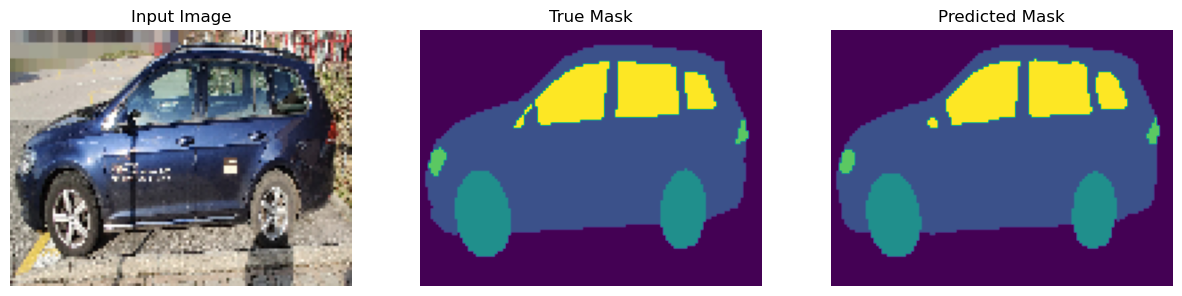

1/1 [==============================] - 0s 32ms/step


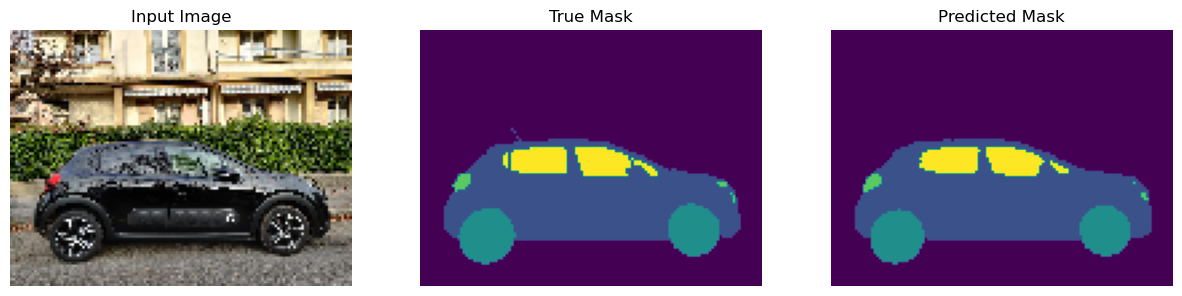

1/1 [==============================] - 0s 24ms/step


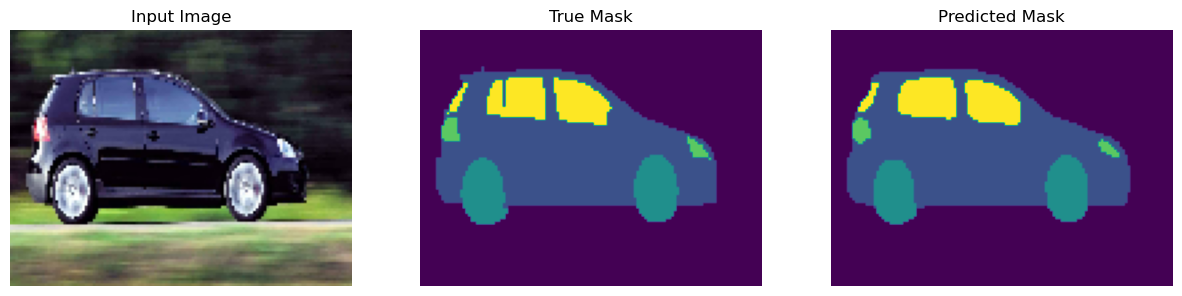

1/1 [==============================] - 0s 23ms/step


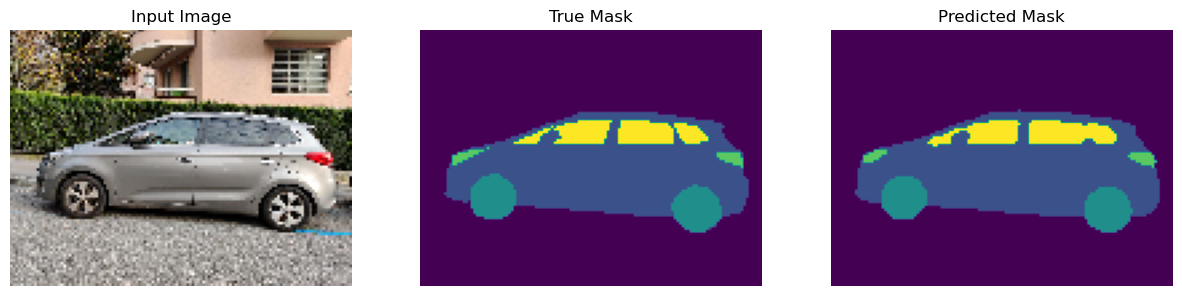

1/1 [==============================] - 0s 87ms/step


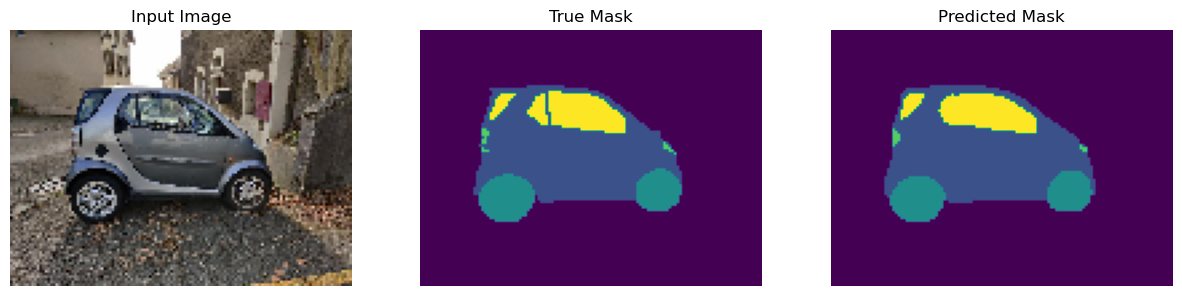

1/1 [==============================] - 0s 22ms/step


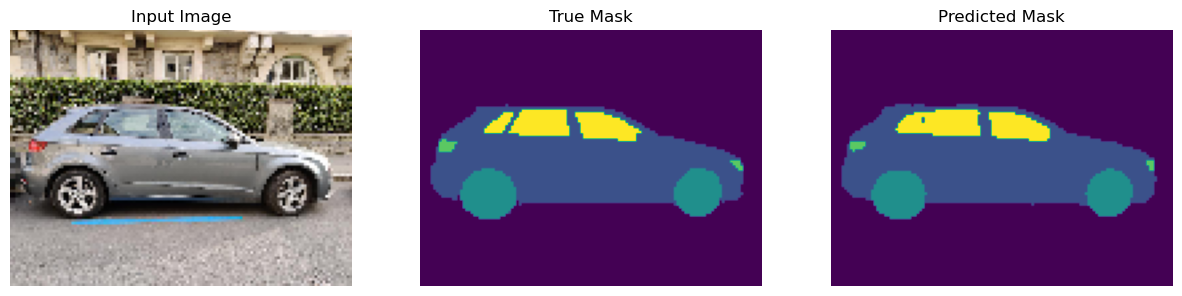

In [95]:
show_predictions(train_dataset,6)

In [96]:
def get_product(x: int, y:int) -> int:
    return x *y

In [98]:
get_product('2',3)

'222'